## [참고]
### https://cocoa-t.tistory.com/entry/PyHessian-Loss-Landscape-%EC%8B%9C%EA%B0%81%ED%99%94-PyHessian-Neural-Networks-Through-the-Lens-of-the-Hessian

In [9]:
#!pip install pyhessian
#!pip install pytorchcv

In [10]:
%load_ext autoreload
%autoreload 2

from pyhessian import hessian
import numpy as np

from pytorchcv.model_provider import get_model as ptcv_get_model # model

import sys, os

import easydict

import torch
import torch.nn as nn
import numpy as np

import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder

from few_shot_learning_system import MAMLFewShotClassifier
from utils import loss_landscape_join

# 0. Dataset 지정하기

In [12]:
dataset="mini_imagenet_full_size"
# dataset="tiered_imagenet"
# dataset="CIFAR_FS"
# dataset="CUB"

title = 'miniImageNet'
# title = 'tieredImageNet'
# title = 'CIFAR-FS'
# title = 'CUB'

# 1. MAML 모델 불러오기

In [13]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args_maml = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":dataset,
  "dataset_path":dataset,
  "reset_stored_paths":False,
  "experiment_name":"../MAML_5way_5shot_filter64",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "smoothing": False,
  "knowledge_distillation": False,
  "momentum": "SGD"
}
)

device = torch.cuda.current_device()
args_maml.im_shape = (2, 3, args_maml.image_height, args_maml.image_width)

args_maml.use_cuda = torch.cuda.is_available()
args_maml.seed = 104
args_maml.reverse_channels=False
args_maml.labels_as_int=False
args_maml.reset_stored_filepaths=False
args_maml.num_of_gpus=1

args_maml.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


## 2. Arbiter 불러오기

In [14]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args_arbiter = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":dataset,
  "dataset_path":dataset,
  "reset_stored_paths":False,
  "experiment_name":"../MAML+Arbiter_5way_5shot_filter64",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 150,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.0001,
  "meta_learning_rate":0.0001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": True,
  "use_bias": True,
  "smoothing": False,
  "knowledge_distillation": False,
  "momentum": "SGD"
}
)

device = torch.cuda.current_device()
args_arbiter.im_shape = (2, 3, args_arbiter.image_height, args_arbiter.image_width)

args_arbiter.use_cuda = torch.cuda.is_available()
args_arbiter.seed = 104
args_arbiter.reverse_channels=False
args_arbiter.labels_as_int=False
args_arbiter.reset_stored_filepaths=False
args_arbiter.num_of_gpus=1

args_arbiter.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


## 3. Model 구성하기

### 3.1. MAML Model 구성하기

In [15]:
# 모델을 구성한다
model_maml = MAMLFewShotClassifier(args=args_maml, device=device,
                              im_shape=(2, 3,
                                        args_maml.image_height, args_maml.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model_maml, data=data, args=args_maml, device=device)

Using max pooling
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
Inner Loop parameters
Outer Loop parameters
log_dir ===  C:\Users\JM\PycharmProjects\MAML\MAML_5way_5shot_filter64
attempting to find existing checkpoint
dataset_splits ==  dict_keys(['test', 'train', 'val'])
data {'test': 12000, 'train': 38400, 'val': 9600}
train_seed 985773, val_seed: 985773, at start time
50000 50000


### 3.2.  Arbiter 구성하기

In [16]:
# 모델을 구성한다
model_arbiter = MAMLFewShotClassifier(args=args_arbiter, device=device,
                              im_shape=(2, 3,
                                        args_arbiter.image_height, args_arbiter.image_width))

data = MetaLearningSystemDataLoader

arbiter_system = ExperimentBuilder(model=model_arbiter, data=data, args=args_arbiter, device=device)

Using max pooling
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
Inner Loop parameters
Outer Loop parameters
log_dir ===  C:\Users\JM\PycharmProjects\MAML\MAML+Arbiter_5way_5shot_filter64
attempting to find existing checkpoint
dataset_splits ==  dict_keys(['test', 'train', 'val'])
data {'test': 12000, 'train': 38400, 'val': 9600}
train_seed 985773, val_seed: 985773, at start time
50000 75000


## 0. 모델 상태 확인

In [17]:
maml_system.state

{'best_val_acc': 0.6116666648785273,
 'best_val_iter': 45500,
 'current_iter': 50000,
 'best_epoch': 91,
 'train_loss_mean': 0.5506827815175056,
 'train_loss_std': 0.1347330680555223,
 'train_accuracy_mean': 0.7948933341503144,
 'train_accuracy_std': 0.05953420825581363,
 'train_loss_importance_vector_0_mean': 0.006000000052154064,
 'train_loss_importance_vector_0_std': 0.0,
 'train_loss_importance_vector_1_mean': 0.006000000052154064,
 'train_loss_importance_vector_1_std': 0.0,
 'train_loss_importance_vector_2_mean': 0.006000000052154064,
 'train_loss_importance_vector_2_std': 0.0,
 'train_loss_importance_vector_3_mean': 0.006000000052154064,
 'train_loss_importance_vector_3_std': 0.0,
 'train_loss_importance_vector_4_mean': 0.9760000109672546,
 'train_loss_importance_vector_4_std': 0.0,
 'train_learning_rate_mean': 0.0010000000000000005,
 'train_learning_rate_std': 4.336808689942018e-19,
 'val_loss_mean': 1.0046450330813725,
 'val_loss_std': 0.1571665716406741,
 'val_accuracy_mean': 

In [18]:
arbiter_system.state

{'best_val_acc': 0.6682222226262092,
 'best_val_iter': 14000,
 'current_iter': 50000,
 'best_epoch': 28,
 'train_loss_mean': 0.3552659073024988,
 'train_loss_std': 0.11188082095213106,
 'train_accuracy_mean': 0.8689599990844726,
 'train_accuracy_std': 0.05070948533209209,
 'train_loss_importance_vector_0_mean': 0.006000000052154064,
 'train_loss_importance_vector_0_std': 0.0,
 'train_loss_importance_vector_1_mean': 0.006000000052154064,
 'train_loss_importance_vector_1_std': 0.0,
 'train_loss_importance_vector_2_mean': 0.006000000052154064,
 'train_loss_importance_vector_2_std': 0.0,
 'train_loss_importance_vector_3_mean': 0.006000000052154064,
 'train_loss_importance_vector_3_std': 0.0,
 'train_loss_importance_vector_4_mean': 0.9760000109672546,
 'train_loss_importance_vector_4_std': 0.0,
 'train_learning_rate_mean': 0.0010000000000000005,
 'train_learning_rate_std': 4.336808689942018e-19,
 'val_loss_mean': 0.9532056687275569,
 'val_loss_std': 0.16697529376818385,
 'val_accuracy_mean'

# 1. 학습된 모델을 불러온다

### 1.1 MAML

In [19]:
model_save_dir = maml_system.saved_models_filepath
model_name = "train_model"
model_idx = maml_system.state['best_epoch']

state = maml_system.model.load_model(model_save_dir=model_save_dir,
                                     model_name=model_name,
                                     model_idx=model_idx)

state_dict_loaded = state['network']

maml_system.model.load_state_dict(state_dict=state_dict_loaded)

# # 잘 불러왔는지 확인하는 코드
# print("state_dict_loaded == ",state_dict_loaded)
# print("="*10)
# for key, value in maml_system.model.named_parameters():
#     print(key)
#     print(value)

<All keys matched successfully>

In [20]:
# for key, value in maml_system.model.named_parameters():
#     #print(key)
#     if value.requires_grad:
#         print(key)
#         print(value.shape)

### 1.2 Arbiter

In [21]:
model_save_dir = arbiter_system.saved_models_filepath
model_name = "train_model"
model_idx = arbiter_system.state['best_epoch']

state = arbiter_system.model.load_model(model_save_dir=model_save_dir,
                                     model_name=model_name,
                                     model_idx=model_idx)

state_dict_loaded = state['network']

arbiter_system.model.load_state_dict(state_dict=state_dict_loaded)

# # 잘 불러왔는지 확인하는 코드
# print("state_dict_loaded == ",state_dict_loaded)
# print("="*10)
# for key, value in maml_system.model.named_parameters():
#     print(key)
#     print(value)

<All keys matched successfully>

# 2. Data를 불러온다

In [22]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/2), augment_images=False)

In [23]:
train_sample = next(train_data)

In [24]:
x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample

x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)


x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task = next(zip(x_support_set,y_support_set,x_target_set, y_target_set))


In [25]:
y_support_set_task

tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]], device='cuda:0')

In [26]:
arbiter_x_support_set, arbiter_x_target_set, arbiter_y_support_set, arbiter_y_target_set, seed = train_sample

arbiter_x_support_set = torch.Tensor(arbiter_x_support_set).float().to(device=arbiter_system.model.device)
arbiter_x_target_set = torch.Tensor(arbiter_x_target_set).float().to(device=arbiter_system.model.device)
arbiter_y_support_set = torch.Tensor(arbiter_y_support_set).long().to(device=arbiter_system.model.device)
arbiter_y_target_set = torch.Tensor(arbiter_y_target_set).long().to(device=arbiter_system.model.device)


arbiter_x_support_set_task, arbiter_y_support_set_task, arbiter_x_target_set_task, arbiter_y_target_set_task = next(zip(arbiter_x_support_set,arbiter_y_support_set,arbiter_x_target_set, arbiter_y_target_set))


In [27]:
arbiter_y_support_set_task

tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]], device='cuda:0')

In [28]:
names_weights_copy = arbiter_system.model.get_inner_loop_parameter_dict(arbiter_system.model.classifier.named_parameters())
        
num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

names_weights_copy = {
    name.replace('module.', ''): value.unsqueeze(0).repeat(
        [num_devices] + [1 for i in range(len(value.shape))]) for
    name, value in names_weights_copy.items()}

n, s, c, h, w = arbiter_x_target_set_task.shape

arbiter_x_support_set_task = arbiter_x_support_set_task.view(-1, c, h, w)
arbiter_y_support_set_task = arbiter_y_support_set_task.view(-1)
arbiter_x_target_set_task = arbiter_x_target_set_task.view(-1, c, h, w)
arbiter_y_target_set_task = arbiter_y_target_set_task.view(-1)

# Inner-loop (Adaptation 과정을 수행한 후, loss function을 구해야하나?)
num_steps=5
for num_step in range(num_steps):            
    support_loss, support_preds, support_loss_seperate, fetaure_map = arbiter_system.model.net_forward(
            x=arbiter_x_support_set_task,
            y=arbiter_y_support_set_task,
            weights=names_weights_copy,
            backup_running_statistics=num_step == 0,
            training=True,
            num_step=num_step,
            training_phase='test',
            epoch=0,
        )

    generated_alpha_params = {}
    
    if arbiter_system.model.args.arbiter:
        support_loss_grad = torch.autograd.grad(support_loss, names_weights_copy.values(),
                                                retain_graph=True)

        names_grads_copy = dict(zip(names_weights_copy.keys(), support_loss_grad))

        per_step_task_embedding = []

        for key, weight in names_weights_copy.items():
            weight_norm = torch.norm(weight, p=2)
            per_step_task_embedding.append(weight_norm)

        for key, grad in names_grads_copy.items():
            gradient_l2norm = torch.norm(grad, p=2)
            per_step_task_embedding.append(gradient_l2norm)

        per_step_task_embedding = torch.stack(per_step_task_embedding)

        per_step_task_embedding = (per_step_task_embedding - per_step_task_embedding.mean()) / (
                    per_step_task_embedding.std() + 1e-12)

        generated_gradient_rate = arbiter_system.model.arbiter(per_step_task_embedding)

        g = 0
        for key in names_weights_copy.keys():
            generated_alpha_params[key] = generated_gradient_rate[g]
            g += 1

    names_weights_copy,names_grads_copy = arbiter_system.model.apply_inner_loop_update(loss=support_loss,
                                                                      support_loss_seperate=support_loss_seperate,
                                                      names_weights_copy=names_weights_copy,
                                                      alpha=generated_alpha_params,
                                                      use_second_order=args_arbiter.second_order,
                                                      current_step_idx=num_step,
                                                      current_iter=arbiter_system.state['current_iter'],
                                                      training_phase='test')


for name, param in arbiter_system.model.classifier.named_parameters():
    if param.requires_grad:
        if "norm_layer" not in name:
            param.data = names_weights_copy[name].squeeze().to(device=device)

C:\Users\JM\PycharmProjects\MAML\meta_neural_network_architectures.py:993: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  if param.grad is not None:


In [29]:
names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())
        
        
num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

names_weights_copy = {
    name.replace('module.', ''): value.unsqueeze(0).repeat(
        [num_devices] + [1 for i in range(len(value.shape))]) for
    name, value in names_weights_copy.items()}

n, s, c, h, w = x_target_set_task.shape

x_support_set_task = x_support_set_task.view(-1, c, h, w)
y_support_set_task = y_support_set_task.view(-1)
x_target_set_task = x_target_set_task.view(-1, c, h, w)
y_target_set_task = y_target_set_task.view(-1)

# Inner-loop (Adaptation 과정을 수행한 후, loss function을 구해야하나?)
num_steps=5
for num_step in range(num_steps):            
    support_loss, support_preds, support_loss_seperate, fetaure_map = maml_system.model.net_forward(
            x=x_support_set_task,
            y=y_support_set_task,
            weights=names_weights_copy,
            backup_running_statistics=num_step == 0,
            training=True,
            num_step=num_step,
            training_phase='test',
            epoch=0,
        )

    generated_alpha_params = {}


    names_weights_copy,names_grads_copy = maml_system.model.apply_inner_loop_update(loss=support_loss,
                                                                   support_loss_seperate=support_loss_seperate,
                                                      names_weights_copy=names_weights_copy,
                                                      alpha=generated_alpha_params,
                                                      use_second_order=args_maml.second_order,
                                                      current_step_idx=num_step,
                                                      current_iter=maml_system.state['current_iter'],
                                                      training_phase='test')


for name, param in maml_system.model.classifier.named_parameters():
    if param.requires_grad:
        if "norm_layer" not in name:
            param.data = names_weights_copy[name].squeeze().to(device=device) 

## landscape 함수 그리기

inputs shape==  torch.Size([25, 3, 84, 84])
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
No inner loop params
tensor([ 1.5249e-03,  2.5939e-03,  9.9636e-04, -2.2071e-03,  3.3533e-04,
        -5.8379e-04, -2.8012e-03, -1.7969e-03,  1.1807e-03,  2.2465e-03,
         1.9939e-03,  3.0633e-04,  2.9469e-03, -1.6753e-03,  9.6097e-04,
         3.2720e-04, -1.8252e-04,  3.5936e-03,  2.9323e-03, -1.2352e-04,
        -3.5142e-03,  2.7021e-03, -1.3823e-03, -4.8046e-03, -1.2189e-03,
        -1.0183e-03, -2.0403e-03,  1.9734e-03,  6.8108e-04,  2.3642e-03,
         1.0462e-03, -3.8390e-03, -1.0657e-03, -3.9016e-04, -1.1164e-03,
        -3.4185e-03,  3.7633e-04,  2.3697e-04,  5.6810e-04,  3.2179e-03,
        -5.9915e-03, -1.7371e-04, -2.0750e-05,  3.6499e-04,  1.9583e-03,
         1.2003e-03, -3.5386e-03, -1.4886e-03, -1.8121e-03,  7.1004e-04,
        -8.3975e-04,  4.4664e-04,  5.0234e-04,  3.9900e-04

C:\Users\JM\anaconda3\envs\maml\lib\site-packages\torch\autograd\__init__.py:199: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\engine.cpp:1064.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


tensor([ 9.3234e-05, -1.6537e-04,  2.1394e-05, -2.7195e-04, -5.3385e-05,
         1.4124e-04,  1.7165e-04,  5.2831e-04,  4.8400e-05, -2.8307e-05,
         1.0893e-04, -3.5548e-05, -1.3021e-04,  1.9612e-04, -3.2714e-05,
         1.2653e-04, -1.6857e-04,  5.5910e-05, -1.2382e-04,  4.4672e-05,
         2.6159e-04,  6.4523e-05, -2.8308e-04, -2.8123e-04, -5.6220e-05,
        -5.0554e-06, -4.4277e-05,  5.8170e-05,  2.5390e-04, -2.6828e-04,
        -1.3316e-04, -1.4892e-04, -1.8894e-04,  4.7638e-05, -7.7088e-05,
        -4.0302e-05,  1.8341e-04, -1.2855e-05, -1.1027e-04, -1.2956e-04,
         4.9580e-05, -3.1995e-04, -2.0830e-05, -2.2187e-04,  9.3053e-05,
         2.2175e-04,  1.0776e-04,  2.8328e-05,  1.6775e-04, -1.2522e-04,
         1.3997e-05,  1.5810e-04, -5.9695e-06, -1.6364e-04,  1.4273e-04,
         2.0940e-04,  2.7751e-04, -4.0691e-05,  1.4500e-04,  1.7132e-05,
        -1.2797e-04,  2.9938e-05,  5.0914e-06,  4.1263e-05], device='cuda:0',
       grad_fn=<CopyBackwards>)
tensor([[[[-2.

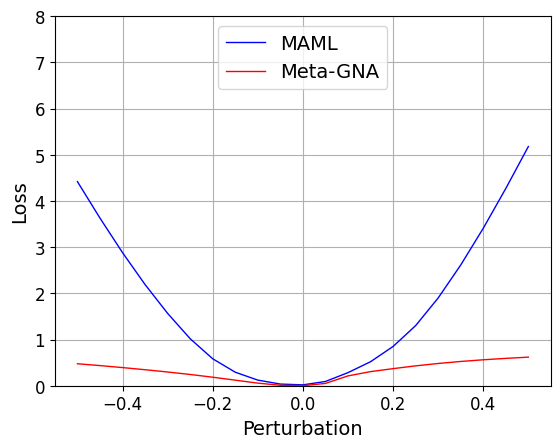

In [30]:
ls = loss_landscape_join.landscape(maml_system.model.classifier, arbiter_system.model.classifier, args_arbiter)
ls.show_2djoin(x_support_set_task, y_support_set_task, title=title)